### Wind Power Generate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# predefined variable
batch_size = 1
epoch = 10
neurons = 10
predict_values = 72
lag = 24

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
# Create a differenced series
def difference(dataset, interval = 1):
    diff = list() # empty list
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [5]:
# invert differeced value
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
def minmaxscaler(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled

In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [9]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

In [10]:
def model_lstm(train, batch_size, epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(LSTM(neurons, stateful=True))
    model.add(Dense(1))
    
    model.compile(loss = 'mean_squared_error', optimizer='adam')

    for i in range(epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)
        
    return model

In [11]:
# Make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [12]:
# Load dataset
data = pd.read_csv('../data/wind-data.csv', index_col='Date/Time')

In [13]:
# head() function shows the first five rows
data.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [14]:
# check the number of rows and columns in the dataset
data.shape

(50530, 4)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50530 entries, 01 01 2018 00:00 to 31 12 2018 23:50
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4)
memory usage: 1.9+ MB


In [16]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [17]:
# check the any null value there in dataset
data.isnull().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [18]:
data.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [19]:
# last five rows
data.tail()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913
31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620


In [20]:
data.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [21]:
# Drop columns
data = data.drop(['Wind Speed (m/s)','Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'], axis=1)

In [22]:
data.head()

,LV ActivePower (kW)
Date/Time,
01 01 2018 00:00,380.047791
01 01 2018 00:10,453.769196
01 01 2018 00:20,306.376587
01 01 2018 00:30,419.645904
01 01 2018 00:40,380.650696


In [23]:
data.shape, data.values

((50530, 1),
 array([[ 380.0477905],
        [ 453.7691956],
        [ 306.3765869],
        ...,
        [2201.106934 ],
        [2515.694092 ],
        [2820.466064 ]]))

In [24]:
# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

In [25]:
diff_values

0          [73.72140509999997]
1        [-147.39260869999998]
2         [113.26931759999997]
3         [-38.99520869999998]
4         [21.741302500000018]
                 ...          
50524     [-550.2880859999996]
50525            [-1279.62793]
50526      [516.7539069999998]
50527      [314.5871580000003]
50528             [304.771972]
Length: 50529, dtype: object

In [26]:
raw_values[:5], diff_values[:5]

(array([[380.0477905],
        [453.7691956],
        [306.3765869],
        [419.6459045],
        [380.6506958]]),
 0      [73.72140509999997]
 1    [-147.39260869999998]
 2     [113.26931759999997]
 3     [-38.99520869999998]
 4     [21.741302500000018]
 dtype: object)

In [27]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag)
supervised_values = supervised.values

In [28]:
# split data into train and test sets
train, test = supervised_values[0:-predict_values], supervised_values[-predict_values:]

In [29]:
# transform the scale of the data
scaler, train_scaled, test_scaled = minmaxscaler(train, test)

In [30]:
test_scaled[1, 0:-1], test_scaled[1, -1]

(array([0.00949691, 0.00949691, 0.00949691, 0.00949691, 0.00949691,
        0.00949691, 0.00949691, 0.00949691, 0.00949691, 0.00949691,
        0.00949691, 0.00949691, 0.00949691, 0.00949691, 0.00949691,
        0.00949691, 0.00949691, 0.00949691, 0.00949691, 0.00949691,
        0.00949691, 0.00949691, 0.00949691, 0.00949691]),
 np.float64(0.009496908774557555))

In [31]:
model = model_lstm(train_scaled, batch_size, epoch, neurons)

50457/50457 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - loss: 0.0049
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - loss: 0.0045
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - loss: 0.0045
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - loss: 0.0045
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - loss: 0.0046
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - loss: 0.0045
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 104s 2ms/step - loss: 0.0047
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - loss: 0.0045
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - loss: 0.0045
50457/50457 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step - loss: 0.0045


In [32]:
import pickle

with open('../models/wind_power_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [33]:
predictions = list()
expectations = list()
test_pred = list()

for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(model, 1, X)

    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred
    if len(test_pred) > lag + 1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    

    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    # print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [34]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  19.97823143918814


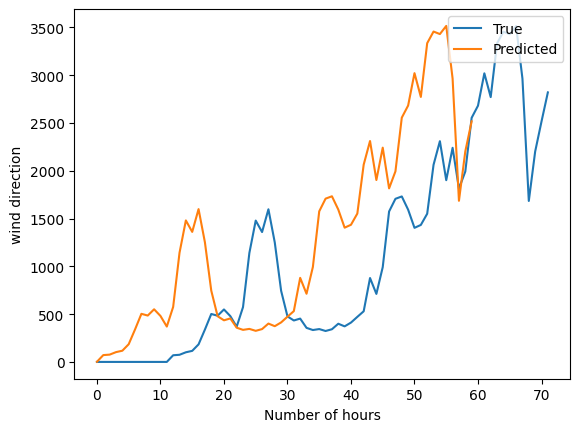

In [35]:
# line plot of observed vs predicted
plt.plot(raw_values[-predict_values:], label="True")
plt.plot(predictions, label="Predicted")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("wind direction")
plt.show()

In [37]:
with open('../models/wind_power_model.pkl', 'rb') as file:
    model = pickle.load(file)